# 19기 Clustering 정규세션 과제

## Clustering 해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. Clustering 
수업 내용 및 실습 자료를 참고하여 클러스터링을 자유롭게 진행해주세요. 한 알고리즘에 대해 파라미터를 바꿔가며 비교를 해도 되고, 여러 알고리즘의 결과를 비교해도 됩니다.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

# Module import

In [173]:
# EDA & Preprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler

# ignore warning
import warnings
warnings.filterwarnings('ignore')

# Clusterer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# vlsualize
import plotly.express as px

# metric
from sklearn.metrics import silhouette_score

## 데이터 불러오기

- Gender : 성별 (Male, Female)
- Age : 나이 (Nemerical)
- Annual Income (k$): 연간 소득 (Nemerical)
- Spending Score (1-100) : 쇼핑몰에서 부여한 고객의 점수

In [123]:
import pandas as pd
df = pd.read_csv("Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## 컬럼 이름 바꾸기

In [124]:
df = df.rename(columns = {'Annual Income (k$)':'Income', 'Spending Score (1-100)':'Score'})
df

,Gender,Age,Income,Score
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


# EDA

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  200 non-null    object
 1   Age     200 non-null    int64 
 2   Income  200 non-null    int64 
 3   Score   200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


"Gender" 컬럼을 제외한 나머지 컬럼들은 모두 연속형 변수들로 이루어져 있음

따로 결측치는 없어보인다.

In [126]:
df.describe()

,Age,Income,Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


## 데이터 분포 살펴보기

In [127]:
print(df.nunique())

Gender     2
Age       51
Income    64
Score     84
dtype: int64


Categorical 변수인 Gender의 분포를 살펴보자.

In [128]:
print("column : Gender")
print(df['Gender'].value_counts())
print('='*80)

column : Gender
Female    112
Male       88
Name: Gender, dtype: int64


## Visualize Categorical Variable

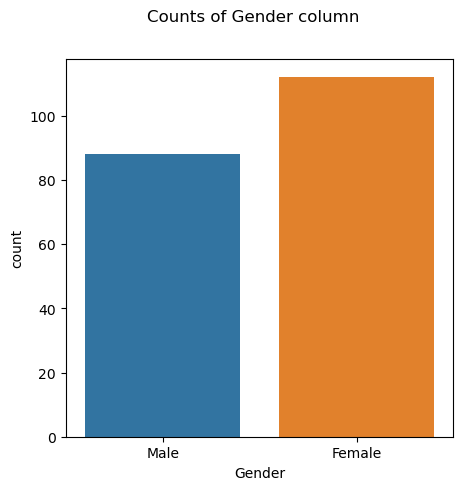

In [129]:
fig = plt.figure(figsize = (5,5), dpi = 100)

fig.suptitle("Counts of Gender column")

sns.countplot(x = 'Gender', data=df)
plt.show()

## Visualize Continuous Variables

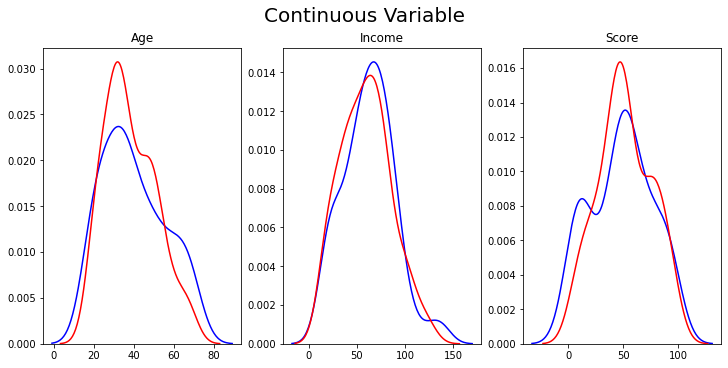

In [130]:
con_col = ['Age', 'Income', 'Score']

fig, ax = plt.subplots(1,3, figsize = (10, 5), constrained_layout=True)
ax = ax.flatten()
fig.suptitle('Continuous Variable', fontsize = 20)

for i in range(len(con_col)):
    sns.distplot(df[df['Gender'] == 'Male'][con_col[i]], color = 'Blue', ax = ax[i], hist = False).set(xlabel=None, ylabel=None)
    sns.distplot(df[df['Gender'] == 'Female'][con_col[i]], color = 'Red', ax = ax[i], hist = False).set(xlabel=None, ylabel=None)
    ax[i].set(title = con_col[i])
    
plt.show()

- 남자 : 파란색
- 여자 : 빨간색


- 여자와 남자의 나이, 수입, 점수에 대한 분포는 비슷해보인다.

## 상관관계

In [131]:
df_corr = df.corr()
display(df_corr)

,Age,Income,Score
Age,1.000000,-0.012398,-0.327227
Income,-0.012398,1.000000,0.009903
Score,-0.327227,0.009903,1.000000


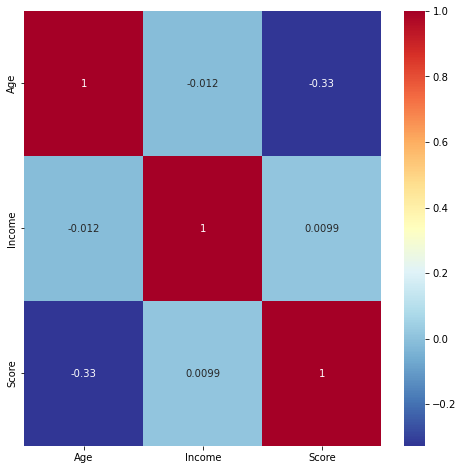

In [132]:
fig = plt.figure(figsize = (8,8))
sns.heatmap(df_corr, annot=True, cmap='RdYlBu_r')
plt.show()

- 다른 column 들에 비해 **Age** 컬럼과 **Score** 컬럼의 상관관계가 높게 나왔다.

# Data Preprocessing

## Categorical 변수 삭제

- 클러스터링 하는데 범주화 변수는 필요없으므로 삭제한다.

In [133]:
df = df.iloc[:, 1:]
df

,Age,Income,Score
CustomerID,,,
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40
...,...,...,...
196,35,120,79
197,45,126,28
198,32,126,74


## symmetric  distribution 확인
- k-means 기법을 사용하기 위해서는 데이터가 symmetric  할 필요가 있다.
- Age, Income, Score 변수들의 distribution 을 보고 symmetric  살펴본 후 만약 아니라면 정규화시켜 주어야 한다.

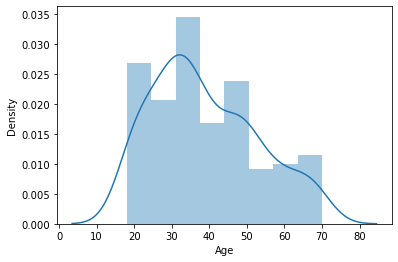

In [81]:
sns.distplot(df['Age'])
plt.show()

- Age 변수의 경우 30~40 의 경우가 가장 많으며 오른쪽 꼬리가 길기 때문에 right-skewed 되어 있음을 확인할 수 있다.

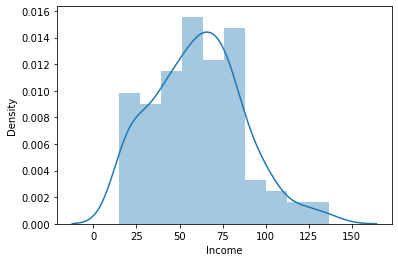

In [82]:
sns.distplot(df['Income'])
plt.show()

- 50~100k 의 소득을 가지는 경우가 가장 많으며, 오른쪽으로 꼬리가 길기 때문에 right-skewed 되어있음을 알 수 있다.

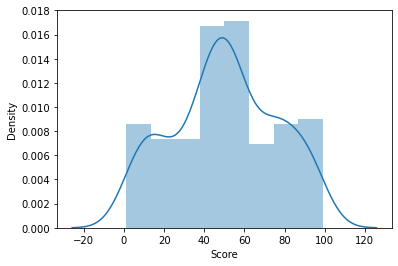

In [83]:
sns.distplot(df['Score'])
plt.show()

- Score 변수의 경우 symmetric 한 분포로 보인다.

## log transformation

- Skewed 변수들 Symmetric하게 변환
- skewness 한 변수들을 조정하기 위해서 log transformation 을 사용하였다.
- 변환해야할 변수들 모두 0보다 크기 때문에 log transformation을 사용하는데 무리는 없어 보인다.


In [84]:
df_log = np.log(df)

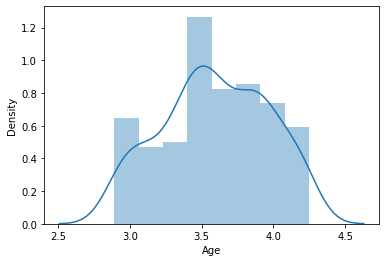

In [85]:
sns.distplot(df_log['Age'])
plt.show()

변수의 분포가 Symmetric 하게 변하였음

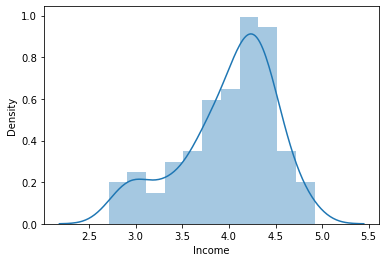

In [86]:
sns.distplot(df_log['Income'])
plt.show()

변수의 분포가 어느정도 symmetric 하게 조정되었음

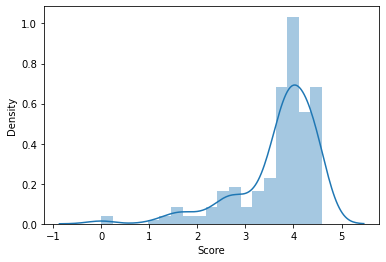

In [87]:
sns.distplot(df_log['Score'])
plt.show()

변수의 분포가 오히려 더 skewed 되었으므로 Score 변수는 따로 log transformation 을 하지 않기로 하였음

In [88]:
df_log['Score'] = df['Score']
df_log

,Age,Income,Score
CustomerID,,,
1,2.944439,2.708050,39
2,3.044522,2.708050,81
3,2.995732,2.772589,6
4,3.135494,2.772589,77
5,3.433987,2.833213,40
...,...,...,...
196,3.555348,4.787492,79
197,3.806662,4.836282,28
198,3.465736,4.836282,74


## Standardization

clustering을 사용하기 위해 표준화 작업을 해주었다. 즉, 평균과 분산이 같아야 하므로 확인 후 변경 여부를 결정하였다.

In [89]:
df_log.describe()

,Age,Income,Score
count,200.000000,200.000000,200.000000
mean,3.594166,3.991378,50.200000
std,0.367069,0.507336,25.823522
min,2.890372,2.708050,1.000000
25%,3.358523,3.725472,34.750000
50%,3.583519,4.119004,50.000000
75%,3.891820,4.356709,73.000000
max,4.248495,4.919981,99.000000


Age, Income의 경우는 비슷하지만 Score변수와 차이가 나므로 표준화 작업을 해주었다.

In [90]:
scaler = StandardScaler()

scaler.fit(df_log)
df_scaled = scaler.transform(df_log)

잘 표준화가 되었는지 확인

In [91]:
print(f"mean : {df_scaled.mean(axis=0).round(2)}")
print(f"std : {df_scaled.std(axis=0).round(2)}")

mean : [ 0. -0. -0.]
std : [1. 1. 1.]


# Clustering

## Hierarchical Clustering

### Hierarchical Clustering Option

affinity: 유사도 측정에 사용할 거리 척도 
+ euclidean
+ manhattan
+ cosine
+ precomputed (others)

linkage: 군집 간 거리 계산 척도
+ single (min)
+ complete (max)
+ average
+ ward

### Hierarchical Clustering 모델 정의

+ Linkage: complete(max)
+ Distance: euclidean
+ Threshold: 5

Threshold: 덴드로그램의 y축에서 군집을 나누는 기준이 된다.밑에 덴드로그램 그려보기에서 threshold 값을 바꿔가며 비교해보자.

In [285]:
# 모델 정의
model = AgglomerativeClustering(
    linkage='complete',  # 최소값으로 거리 계산
    affinity='euclidean',  # 거리 척도 : 유클리드 거리
    distance_threshold=5,  # y축에서 군집을 나누는 기준
    n_clusters=None)  # 클러스터의 개수를 따로 정해주지는 않음

# 학습
clusters = model.fit_predict(df_scaled)

### 실루엣 계수 확인

In [286]:
mean_score = silhouette_score(df_scaled, clusters)
print(mean_score)

0.26004893231491044


In [115]:
print(df_scaled.shape)
print(np.unique(clusters))

(200, 3)
[0 1 2]


In [134]:
df_hi = df.copy()

In [135]:
df_hi['cluster'] = clusters
df_hi

,Age,Income,Score,cluster
CustomerID,,,,
1,19,15,39,0
2,21,15,81,2
3,20,16,6,0
4,23,16,77,2
5,31,17,40,0
...,...,...,...,...
196,35,120,79,1
197,45,126,28,1
198,32,126,74,1


### cluster 별 각 변수들 비교

In [140]:
df_hi = df_hi.groupby('cluster').mean()
df_hi

,Age,Income,Score
cluster,,,
0,33.100000,45.640000,32.640000
1,43.429688,72.375000,52.046875
2,25.272727,25.727273,79.363636


<AxesSubplot:xlabel='cluster'>

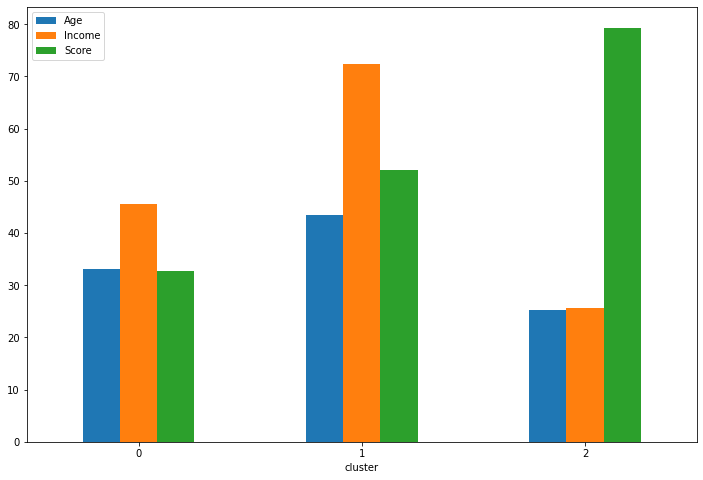

In [145]:
df_hi.plot.bar(figsize=(12,8), rot=0)

- 0번 군집
    - 나이는 30대 중반이며, 수익은 평균적인 수치를 보이고 있다.
    - score를 보니 다른 군집에 비해 가장 낮은 모습을 보이고 있다.
    

- 1번 군집
    - 나이는 40대 중반이며, 수익은 모든 군집에서 가장 최상이다.
    - 점수는 평균적인 수치가 나왔다.
    
    
- 2번 군집
    - 가장 의아한 군집이다.
    - 나이와 수익 모두 다른 군집에 비해 가장 낮지만, score는 가장 최상이다.
    
    
- 오히려 나이와 수익이 적을 수록 attitude가 좋아 쇼핑몰에서 좋은 점수?를 부여하는가 싶다 라는 결론이 나왔다.
- 다른 군집 기법들도 확인해 보고 비슷한 결과가 나온다면 위 가정에 근거가 생길 듯 하다.

### Dendrogram 그려보기

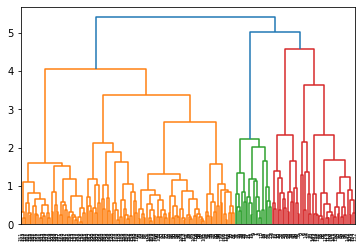

In [146]:
linkage_matrix = linkage(df_scaled, method='complete', metric='euclidean')
_ = dendrogram(linkage_matrix, color_threshold = 5)

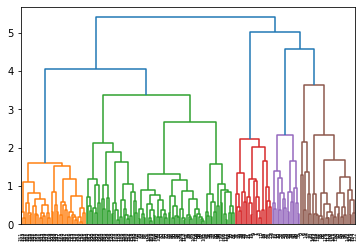

In [150]:
_ = dendrogram(linkage_matrix, color_threshold = 4)

Threshold 를 4로 낮추니 군집의 개수가 5개가 되는 것을 확인할 수 있었다.
- 다시 Threshold를 조정하여 군집화를 시행해보자

### Threshold 조정 후 다시 학습

In [276]:
# 모델 정의
model = AgglomerativeClustering(
    linkage='complete',  # 최소값으로 거리 계산
    affinity='euclidean',  # 거리 척도 : 유클리드 거리
    distance_threshold=4,  # y축에서 군집을 나누는 기준
    n_clusters=None)  # 클러스터의 개수를 따로 정해주지는 않음

# 학습
clusters = model.fit_predict(df_scaled)

### 실루엣 계수 확인

In [280]:
mean_score = silhouette_score(df_scaled, clusters)
print(mean_score)

0.35284888122809166


### Cluster 별 각 변수들 비교

In [281]:
df_hi = df.copy()

In [282]:
df_hi['cluster'] = clusters
df_hi

,Age,Income,Score,cluster
CustomerID,,,,
1,19,15,39,0
2,21,15,81,2
3,20,16,6,0
4,23,16,77,2
5,31,17,40,0
...,...,...,...,...
196,35,120,79,4
197,45,126,28,1
198,32,126,74,4


In [283]:
df_hi = df_hi.groupby('cluster').mean()
df_hi

,Age,Income,Score
cluster,,,
0,23.636364,53.484848,38.909091
1,48.134831,66.168539,38.865169
2,25.272727,25.727273,79.363636
3,51.470588,30.411765,20.470588
4,32.692308,86.538462,82.128205


<AxesSubplot:xlabel='cluster'>

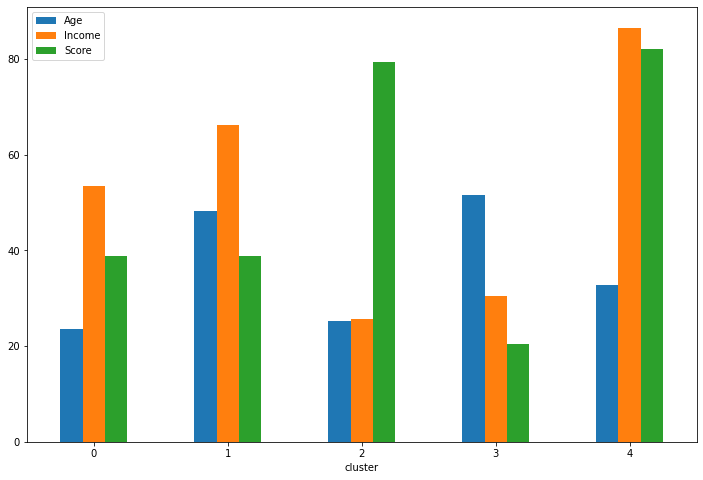

In [284]:
df_hi.plot.bar(figsize=(12,8), rot=0)

위 군집에서 의아하게 생각했던 나이와 수입이 적을 수록 점수가 높았던 것과 관련있는 군집은 2번 군집으로 존재했다.

하지만 수입이 최상위로 높은 군집인 4번 군집이 2번 군집과 score가 비슷하게 보이는 것을 보아 다음과 같은 결론이 나온다.

- 수입은 점수와 크게 상관이 없다.
- 나이는 적을 수록 점수가 올라간다.

## K-means Clustering

### K-Means Clustering Options

n_cluster: 군집 개수
+ K-means 군집화는 군집 개수를 사전에 설정해야 함

init: K-means 군집화의 초기 군집 중심을 설정하는 방법
+ random (완전히 random 하게 설정)
+ k-means++ (초기 군집 중심을 설정하는 알고리즘)

n_init: 서로 다른 초기 군집 중심을 사용하여 K-means 알고리즘을 반복할 횟수
+ n_init 횟수만큼 K-means를 수행한 뒤 가장 좋은 결과를 출력
+ 클러스터 내 군집 중심까지의 Sum of Squared Distance의 값이 가장 작은 결과

max_iter: K-means 알고리즘에서 업데이트 할 횟수

### Elbow method를 이용해 k값 결정 (SSE 찍어보기)

In [160]:
n_cluster = []
sse = []
for n in range(1, 20, 2):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(df_scaled)
    n_cluster += [n]
    sse += [kmeans.inertia_]

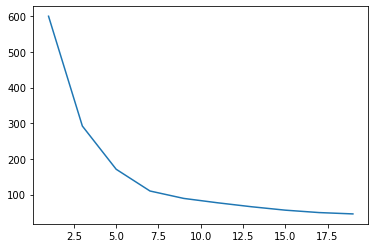

In [161]:
plt.plot(n_cluster, sse)

elbow point를 6으로 결정

In [213]:
n_clusters = 6

In [216]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
kmeans.fit(df_scaled)

KMeans(n_clusters=6)

### 실루엣 계수 확인

In [217]:
mean_score = silhouette_score(df_scaled, kmeans.labels_)
print(mean_score)

0.46420078936459336


여러 실험의 결과 n_clusters가 6 인 경우 실루엣 계수가 가장 컸다.

기준이 되는 0.5와 근접한 수치이니 잘 클러스터링이 되었다고 판단하고 진행

### Cluster 별 각 변수들 비교

In [222]:
df_kmean = df.copy()

In [223]:
df_kmean['cluster'] = kmeans.labels_
df_kmean

,Age,Income,Score,cluster
CustomerID,,,,
1,19,15,39,4
2,21,15,81,4
3,20,16,6,2
4,23,16,77,4
5,31,17,40,2
...,...,...,...,...
196,35,120,79,5
197,45,126,28,1
198,32,126,74,5


In [224]:
df_kmean = df_kmean.groupby('cluster').mean()
df_kmean

,Age,Income,Score
cluster,,,
0,24.027778,57.527778,45.027778
1,43.806452,89.387097,18.645161
2,45.400000,25.650000,18.550000
3,54.490196,54.549020,48.764706
4,25.045455,24.636364,78.181818
5,32.725000,85.825000,81.575000


<AxesSubplot:xlabel='cluster'>

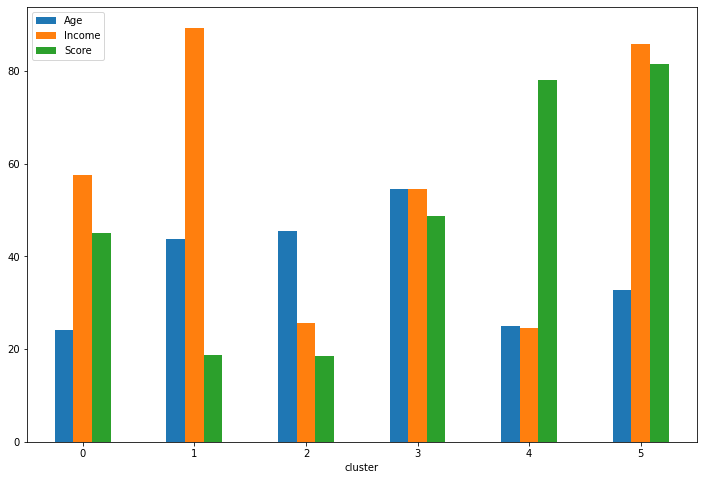

In [225]:
df_kmean.plot.bar(figsize=(12,8), rot=0)

- 0, 4, 5 비교 : 나이가 적지만 연봉이 적으면 오히려 score가 높다. 하지만 연봉이 압도적으로 높으면 score는 높아진다.
- 1, 2, 3 비교 : 나이가 40대 정도가 되면 연봉에 상관없이 score가 낮다.
    - 재미있는 점이 연봉이 압도적으로 높거나 적거나 둘다 score가 낮았다. 오히려 연봉이 평균인 집단의 score가 더 높았다.

## DBSCAN Clustering

### DBSCAN Clustering Option

eps: 핵심 포인트를 중심으로 측정되는 유클리디언 거리값  
min_samples: 핵심 포인트를 중심으로 간주하는 주변 지역의 표본 수

### DBSCAN 모델정의

+ eps = 0.2
+ min_samples = 5
+ metric='euclidean'

In [226]:
# 모델 정의
model = DBSCAN(
    eps = 1,
    min_samples = 5,
    metric='euclidean')

# 학습
clusters = model.fit_predict(df_scaled)

In [229]:
clusters

array([-1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

라벨 값이 엉망이다. 아무래도 파라미터 조정을 해주어야 할 것 같다.

### Hyperparameter tuning
- Elbow Method

min_samples 의 경우 통상적으로 사용되는 4를 사용하자

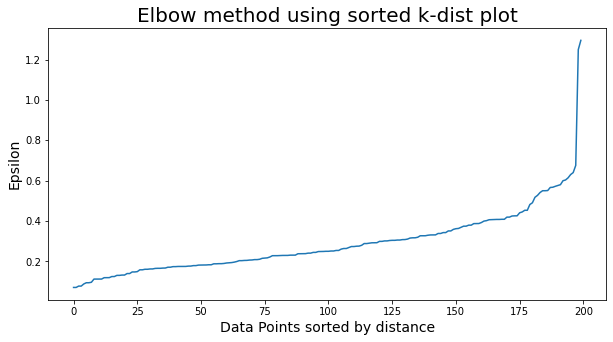

In [238]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=2)
neighbors = nn.fit(df_scaled)
distances, indices = neighbors.kneighbors(df_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('Elbow method using sorted k-dist plot',fontsize=20) # K-distance Graph
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

eps 를 0.5 로 조정

In [304]:
# 모델 정의
model = DBSCAN(
    eps = 0.5,
    min_samples = 5,
    metric='euclidean')

# 학습
model.fit_predict(df_scaled)

array([-1,  0, -1,  0, -1,  0, -1, -1, -1, -1, -1, -1, -1,  0, -1,  0, -1,
       -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1,  2, -1, -1,  1,  2,  2,  2,  1,
        2,  2,  1,  1,  1,  1,  1,  2,  1,  1,  2,  1,  1,  1,  2,  1,  1,
        2,  2,  1,  1,  1,  1,  1,  2,  1,  1,  2,  1,  1,  1,  1,  1,  2,
        1,  1,  2,  1,  1,  1,  2,  1,  1,  1,  2,  1,  2,  1,  2,  2,  1,
        1,  2,  1,  2,  1,  1,  1,  1,  1,  2,  1,  2,  2,  2,  1,  1,  1,
        1,  2,  1, -1,  3, -1,  3,  1,  3,  1,  3,  1,  3,  2,  3, -1,  3,
        1,  3, -1,  3, -1,  3, -1,  3, -1,  3,  1,  3, -1,  3,  1,  3,  1,
        3,  1,  3, -1,  3, -1,  3,  1,  3, -1,  3,  1,  3,  1,  3, -1,  3,
        1,  3,  1,  3,  1,  3,  1,  3,  1,  3, -1,  3,  1,  3, -1,  3,  1,
        3,  1,  3, -1,  3, -1,  3,  1,  3, -1, -1, -1, -1], dtype=int64)

### 실루엣 계수 확인

In [305]:
mean_score = silhouette_score(df_scaled, model.labels_)
print(mean_score)

0.2638453614022101


### Cluster 별 각 변수들 비교

In [263]:
df_db = df.copy()

In [264]:
df_db['cluster']=model.labels_
df_db['cluster'].value_counts()

# 0,1,2는 세 개의 다른 클러스터, -1은 노이즈

 1    71
-1    58
 3    37
 2    28
 0     6
Name: cluster, dtype: int64

In [265]:
df_db

,Age,Income,Score,cluster
CustomerID,,,,
1,19,15,39,-1
2,21,15,81,0
3,20,16,6,-1
4,23,16,77,0
5,31,17,40,-1
...,...,...,...,...
196,35,120,79,3
197,45,126,28,-1
198,32,126,74,-1


노이즈인 행 제거

In [266]:
df_db = df_db[df_db['cluster'] != -1]
df_db

,Age,Income,Score,cluster
CustomerID,,,,
2,21,15,81,0
4,23,16,77,0
6,22,17,76,0
14,24,20,77,0
16,22,20,79,0
...,...,...,...,...
190,36,103,85,3
192,32,103,69,3
194,38,113,91,3


In [268]:
df_db = df_db.groupby('cluster').mean()
df_db

,Age,Income,Score
cluster,,,
0,22.833333,18.666667,77.166667
1,51.802817,63.281690,40.422535
2,24.107143,54.321429,50.464286
3,32.783784,84.108108,82.324324


<AxesSubplot:xlabel='cluster'>

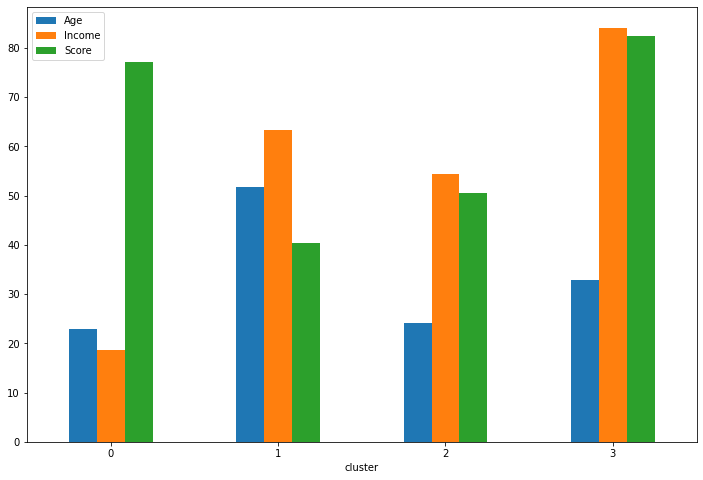

In [269]:
df_db.plot.bar(figsize=(12,8), rot=0)

- 0, 1 군집
    - 지금까지의 결과와 같은 모습을 보여준다.
    - 나이가 20대인 경우 수입이 적으면 score가 올라간다. 
    
- 0, 3 군집
    - 나이가 비슷하지만 수입은 큰 차이가 있다.
    - 하지만 score에는 차이가 크지 않다.
    - 즉 여기에서도 수입과 score는 큰 연관이 없다는 것이 보인다.
    
- 1, 2 군집
    - 다음 두 군집은 연봉은 비슷하지만 나이가 큰 차이를 보인다.
    - 위 결과에서도 나이가 적을 수록 score가 올라간다.